<center><h2>DSCI 100 Group Project Report</h2></center>
<div style="text-align: right"> DSCI 100 008 </div>
<div style="text-align: right"> Group 21 </div>
<div style="text-align: right"> Ellie Wakefield </div>
<div style="text-align: right"> Ryan Lee </div>
<div style="text-align: right"> Samantha Tang </div>
<div style="text-align: right"> Soumil Ahuja </div>

<h3>Introduction</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Heart Disease “Cleveland data set” obtained from the UCI Machine Learning Repository will be used to predict the presence of heart disease. Heart disease is a serious issue occurring in the population, so many are trying to find correlating factors for preventive or curative measures to lessen the risk of getting heart disease. This dataset measures 66 different variables pertaining to heart disease (the target field) for 303 participants, however, all published experiments refer to a select 14 of these variables. The Cleveland database chosen for our classification is the one used by machine learning researchers. In order to determine the presence of heart disease, the dataset uses angiographic status. An angiography is recommended for patients that suffer from angina (chest pain) and is used to determine whether or not someone has heart disease. While the dataset classifies the angiography results into 4 levels of severity, we will simplify this and only look at whether heart disease is present (1) or absent (0). Some of these variables have a stronger correlation to the presence of heart disease than others, so we hypothesized which ones would give us a good classification estimate of the angiographic status of a patient. There are numerous risk factors that pertain to heart disease as well as negative effects when one is struggling with the condition; these were taken into account when determining predictors for this classification model.

<h3>Methods & Results</h3>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


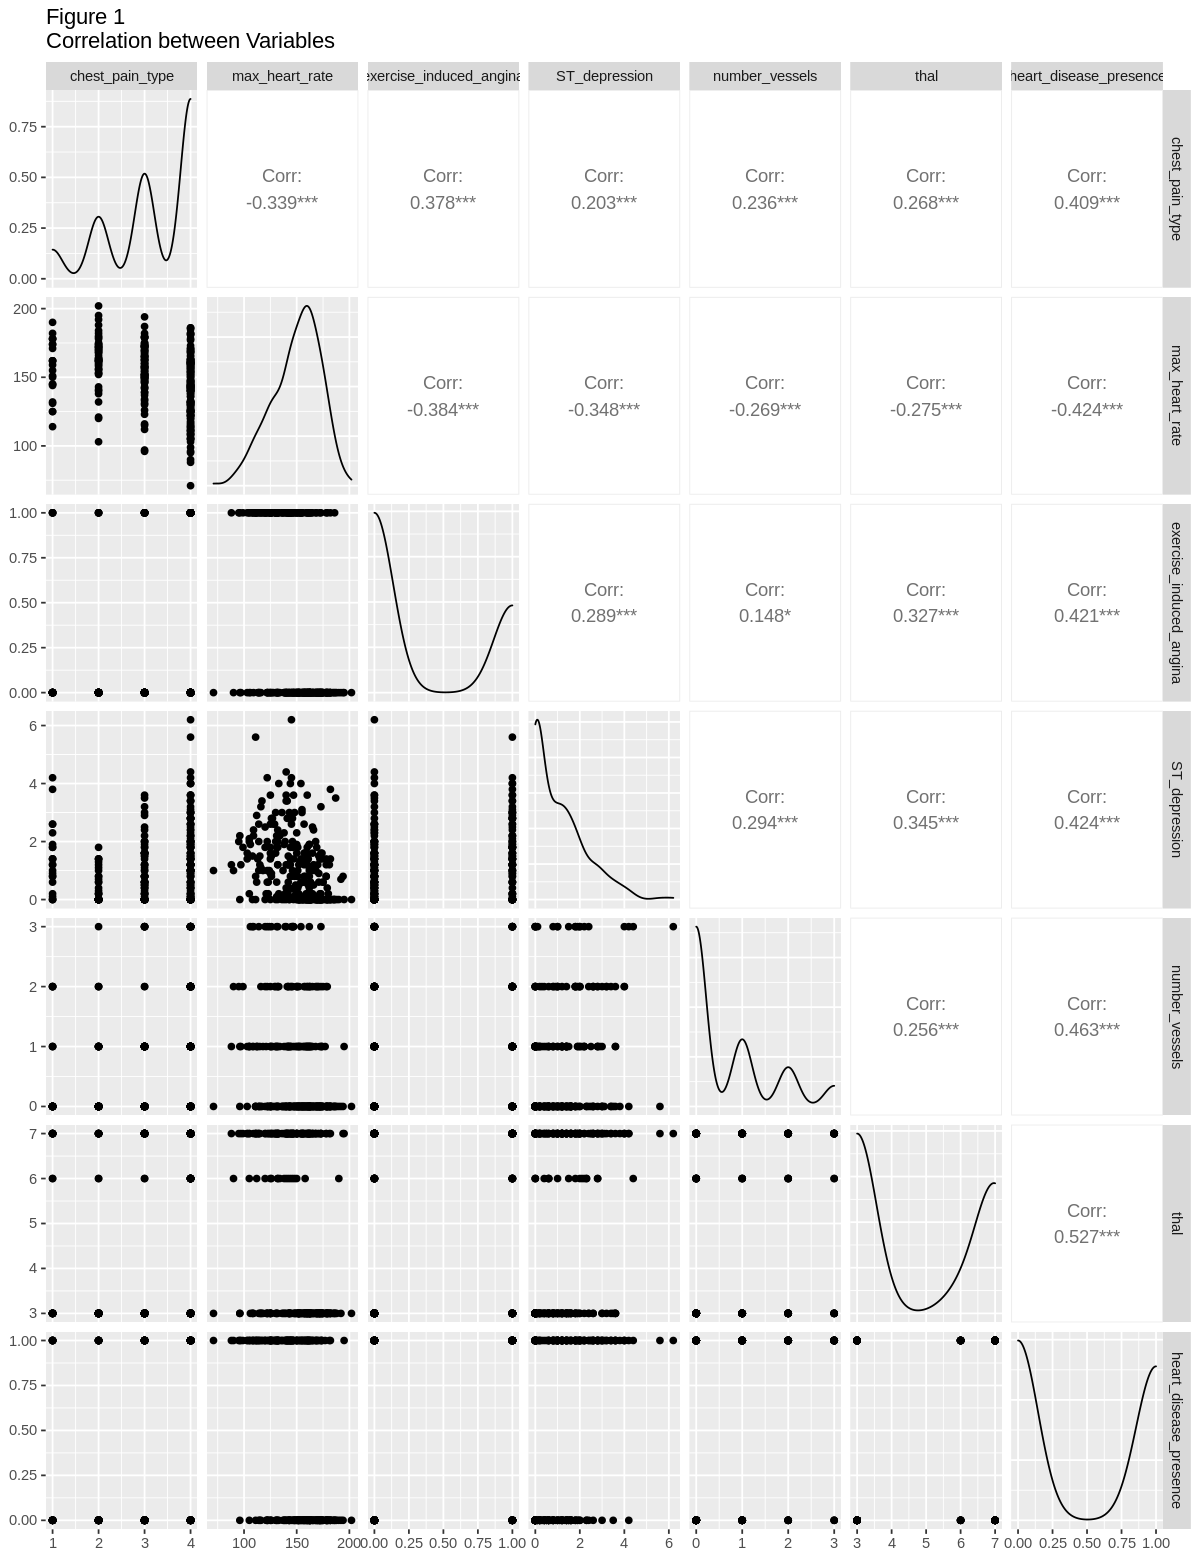

In [2]:
options(repr.plot.width = 10, repr.plot.height = 13)
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    rename(age=X1, sex=X2,chest_pain_type=X3, resting_blood_pressure=X4, serum_cholesteral=X5, fasting_blood_sugar=X6,
           resting_electrocardiographic_results=X7, max_heart_rate=X8, exercise_induced_angina=X9, ST_depression=X10,
           slope=X11, number_vessels=X12, thal=X13, angiographic_status=X14) |>
    mutate(number_vessels=as.double(number_vessels)) |>
    mutate(thal=as.double(thal))
heart_data["heart_disease_presence"] <- 0
for(i in 1:nrow(heart_data)) {
    if(heart_data[i, ncol(heart_data)-1] == 0) {
        heart_data[i, ncol(heart_data)] <- 0
    } else {
        heart_data[i, ncol(heart_data)] <- 1
    }    
}
heart_data <- heart_data |>
    select(chest_pain_type,max_heart_rate,exercise_induced_angina,ST_depression,number_vessels,thal,heart_disease_presence) |>
    na.omit()

figure1 <- ggpairs(heart_data) +
    ggtitle("Figure 1 \nCorrelation between Variables")
figure1

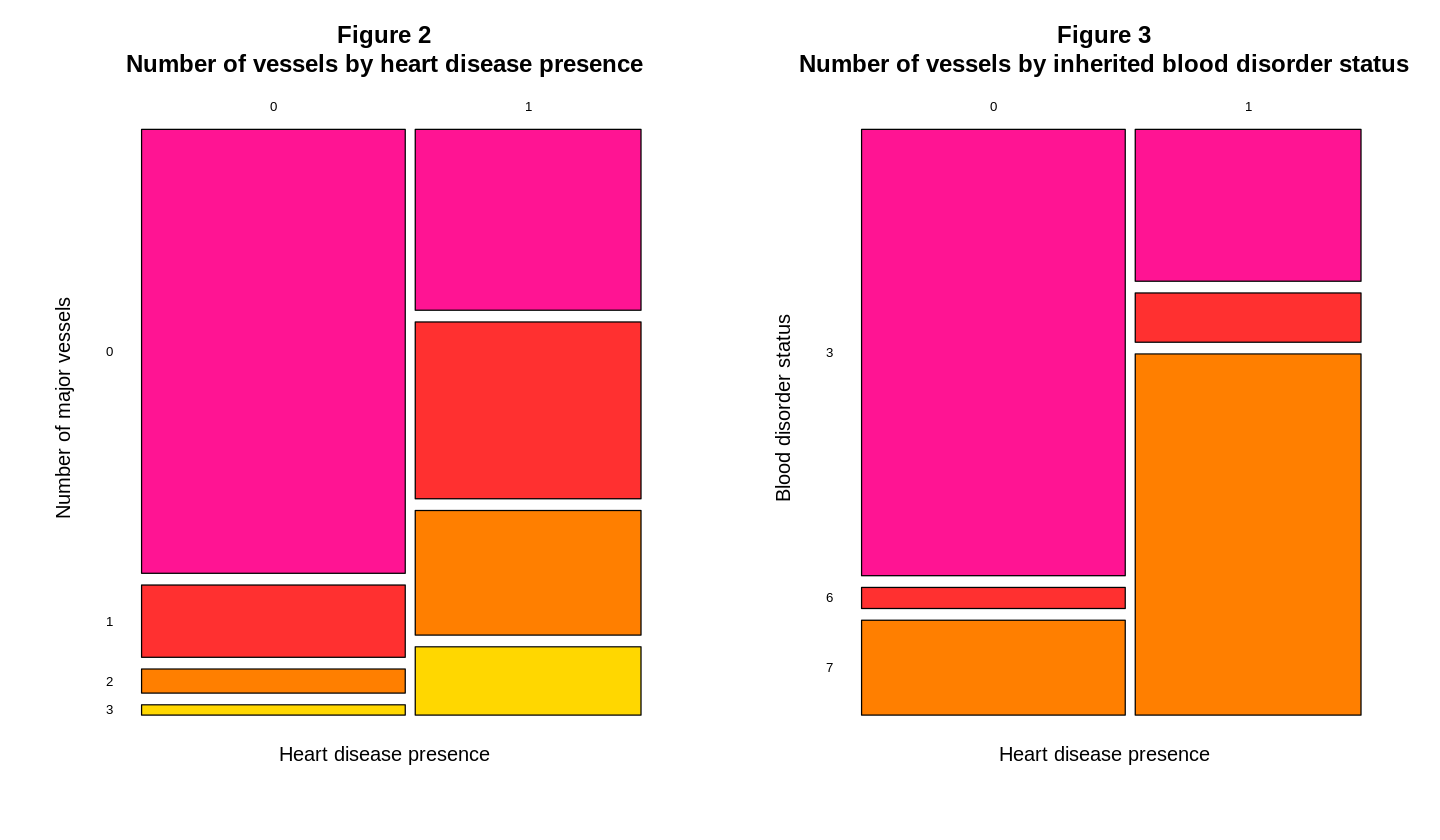

In [3]:
par(mfrow=c(1,2))
options(repr.plot.width = 12, repr.plot.height = 7)

heart_mosaic_vessels <- mosaicplot(heart_disease_presence~number_vessels, 
                           data = heart_data, 
                           col = c("deeppink", "firebrick1", "darkorange1", "gold1"), 
                           main = "Figure 2\nNumber of vessels by heart disease presence",
                          xlab = "Heart disease presence",
                          ylab = "Number of major vessels",
                          las = 1)
    
heart_mosaic_thal <- mosaicplot(data = heart_data,
                               heart_disease_presence ~ thal, 
                               col = c("deeppink", "firebrick1", "darkorange1", "gold1"),
                               main = "Figure 3\nNumber of vessels by inherited blood disorder status",
                               xlab = "Heart disease presence",
                               ylab = "Blood disorder status",
                               las = 1)


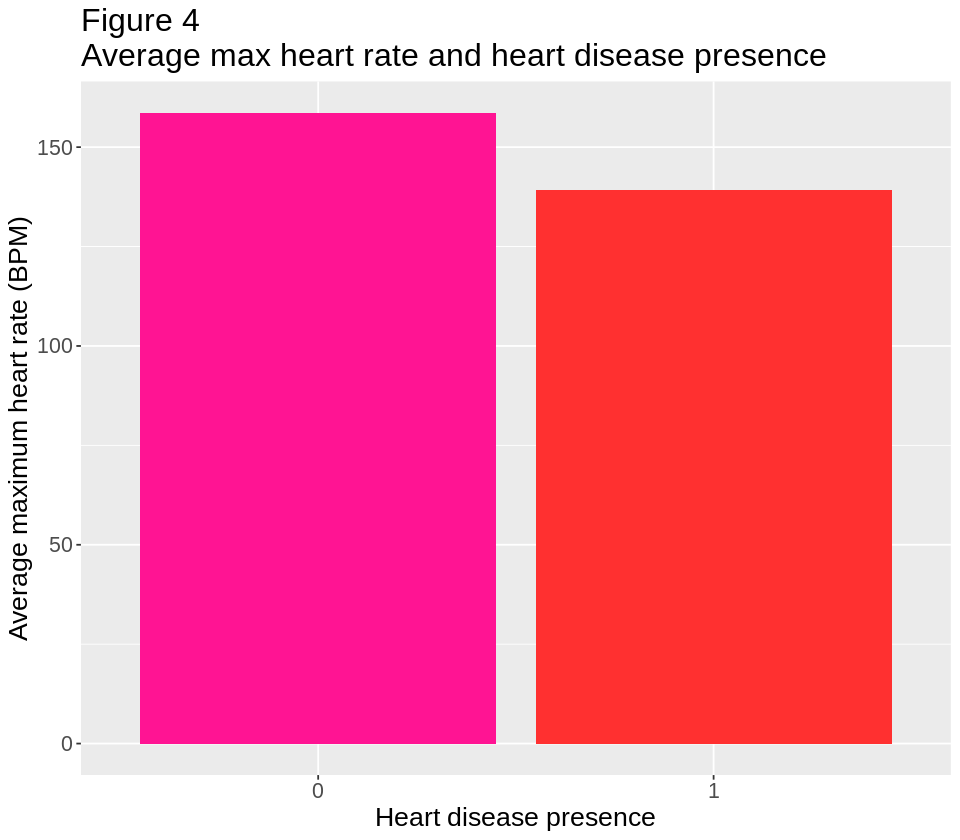

In [4]:
options(repr.plot.width = 8, repr.plot.height = 7)
heart_data <- heart_data |>
    mutate(heart_disease_presence=as.factor(heart_disease_presence))
heart_data_summarized <- heart_data |> 
    select(max_heart_rate, heart_disease_presence) |> 
    group_by(heart_disease_presence) |>
    summarize(mean = mean(max_heart_rate))
#heart_data_summarized
heart_rate_graph <- ggplot(heart_data_summarized, aes(y = mean, x = heart_disease_presence, fill = heart_disease_presence)) + 
    geom_bar(stat = "identity", fill = c("deeppink", "firebrick1")) + 
    labs(x = "Heart disease presence", y = "Average maximum heart rate (BPM)", fill = "Heart disease presence") + 
    theme(text = element_text(size = 16)) + 
    ggtitle("Figure 4\nAverage max heart rate and heart disease presence") 
heart_rate_graph

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.8243083,10,0.02389852,Preprocessor1_Model15


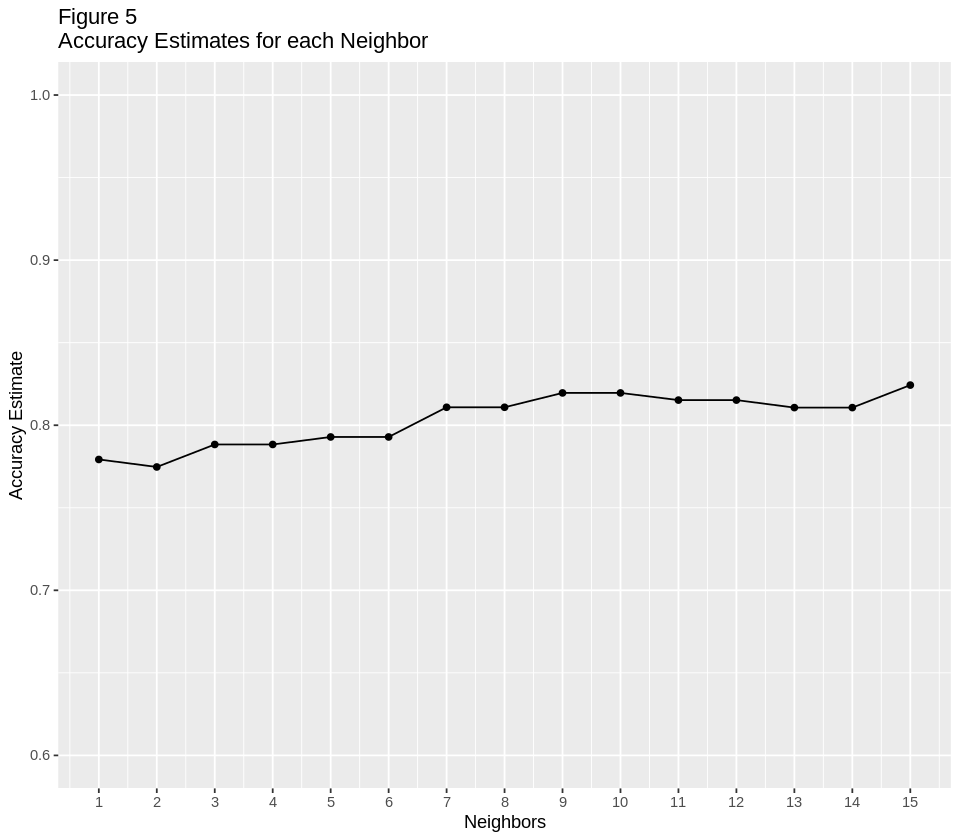

In [5]:
set.seed(1)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease_presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_recipe <- recipe(heart_disease_presence ~., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = heart_disease_presence)

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = heart_vfold, grid = 25) |>
    collect_metrics()
#heart_results
accuracies <- heart_results |>
    filter(.metric == "accuracy")
#max(accuracies$mean)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.6, 1.0))+ # adjusting the y-axis
    ggtitle("Figure 5\nAccuracy Estimates for each Neighbor")
accuracies <- accuracies |>
    filter(.metric == "accuracy") |>
    arrange(mean)
tail(accuracies, 1)
accuracy_versus_k

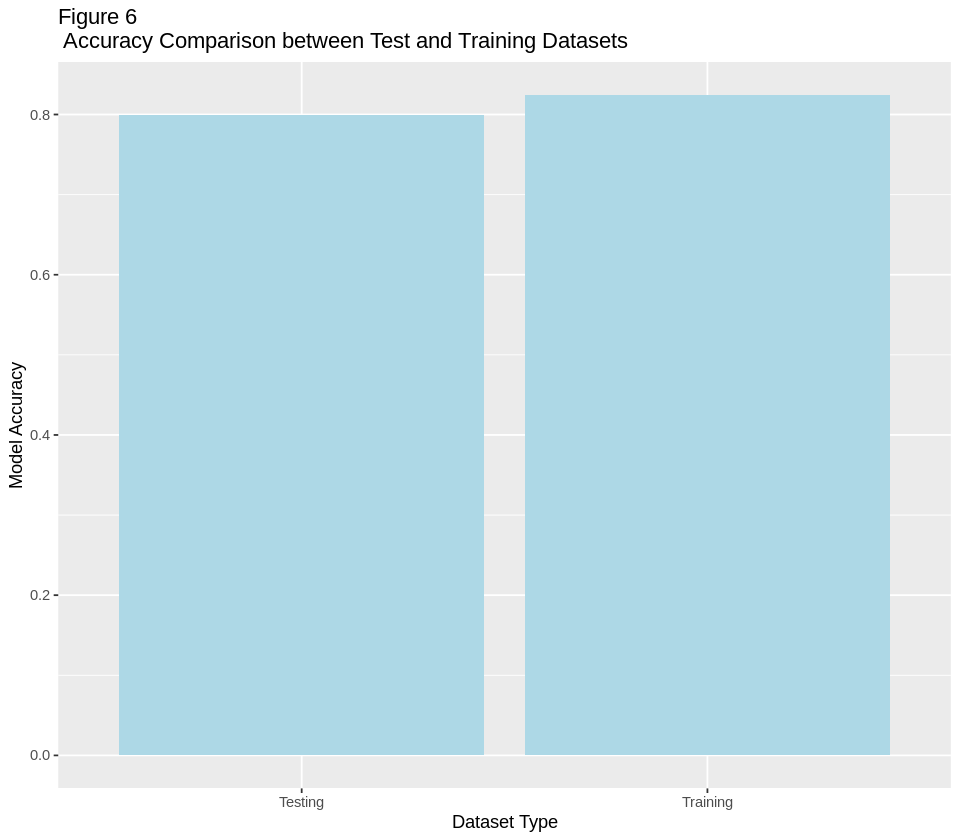

In [6]:
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(heart_spec2) |> 
    fit(data = heart_train)

heart_test_predictions <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)

heart_predictions_accuracy <- heart_test_predictions |>
    metrics(truth = heart_disease_presence, estimate = .pred_class)

test_accuracy <- heart_predictions_accuracy |>
    slice(1) |>
    pull(3)
train_accuracy <- tail(accuracies, 1) |>
    pull(4)

test_train_compare <- data.frame(type = c("Training", "Testing"), result = c(train_accuracy, test_accuracy))
test_train_compare_plot <- ggplot(test_train_compare, aes(y = result, x = type)) +
    geom_bar(stat = "identity", fill = "lightblue") + 
    xlab("Dataset Type") +
    ylab("Model Accuracy") +
    ggtitle("Figure 6\n Accuracy Comparison between Test and Training Datasets")
test_train_compare_plot

In [7]:
cat("Table 1")
heart_mat <- heart_test_predictions |>
   conf_mat(truth = heart_disease_presence, estimate = .pred_class)
heart_mat

Table 1

          Truth
Prediction  0  1
         0 32  7
         1  8 28

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The predictors which we initially chose were the ones that we expected to have a strong correlation with our response variable (presence of heart disease). However, upon further exploratory data analysis, we realized these were not the best predictors to choose. We initially chose the variables age, maximum heart rate, chest pain type, cholesterol, resting blood pressure, and gender as predictors. Once we visualized the correlation of these variables with the response variable using ggpairs(), we discovered that some of these particular variables had quite a low correlation, and we could improve the accuracy of our classifier if we were to instead choose variables with the highest correlation to heart disease presence.  For example, according to the ggpairs() plot the correlation between age and heart disease presence was only 0.227, which is low enough to be insignificant and therefore would not have served as a very good predictor in our classifier.  After realizing this we decided to choose chest pain type, maximum heart rate, exercise induced angina, ST depression, number of major vessels, and presence of blood disorder. These new predictors we chose all had correlations above 0.4, which is a more significant level of correlation that will yield a more accurate classifier (see figure 1). The relationships between these variables and the presence of heart disease were much more pronounced. For example, there is a clear relationship between heart disease presence with the number of major vessels observed through fluoroscopy (see figure 2). This was also the case for beta thalassemia cardiomyopathy, which is an inherited blood disorder (see figure 3). It is worth noting that there was a negative correlation between maximum heart rate and heart disease presence. This simply means that there is an inverse relationship, in other words a lower maximum heart rate is associated with presence of heart disease, rather than lack thereof. The actual graphs shown in our ggpairs() plot was hard to interpret since most of our predictor variables are categorical rather than numerical. This means that the graphs will look more like grids rather than normal scatterplots. Fortunately, these graphs were not very relevant to our analysis, and what was important to us from the plot was the correlation values.

<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
We will use this data set to build a classifier using chest pain, maximum heart rate, exercise induced angina, ST depression, number of major vessels, and if the patient has an inherited blood disorder as predictors for angiographic status/presence of heart disease in a patient. By assessing the accuracy of this classifier, we can get an idea of the correlation of the predictor variables with the response variable, and subsequently assess if this will be a helpful classifier or if additional factors need to be considered.

<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Chest pain refers to angina, which is caused by a decreased flow of blood to the heart, where one feels pressure, pain, or heaviness in the chest. In this data set, chest pain type is split into four values, where value 1 represents normal angina, value 2 represents atypical angina, value 3 represents non-anginal pain, and value 4 is asymptomatic. Maximum heart rate achieved is represented as thalach in the data set, while exercised induced angina is a common recurrence for those that have heart disease, where angina appears during initial exercise (Bogaty et al., 2003). Poste et al. (2007) observed that ST depression is due to some blockage of a coronary artery that causes a down-sloping depression on an electrocardiogram. In addition, the number of major vessels observed through fluoroscopy are indicated. Beta thalassemia cardiomyopathy is an inheritable autosomal recessive disorder where the body makes less hemoglobin than the average human (Galanello & Origa, 2010). This value in the Cleveland dataset is split into three variables; normal, fixed defect, and reversible defect.

<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
We are predicting  the presence of heart disease (a categorical variable) for an observation based on its predictors. We first converted the character data type to a factor data type. In order to train our K-nearest neighbor classifier, we used our predictors of chest pain type, maximum heart rate, exercise-induced angina, ST depression, number of major blood vessels, and the presence of a blood disorder. The Cleveland Data Set will be split up into a training and a testing group, with a 75/25 split, giving us two separate data frames to work on. K-nearest neighbors are sensitive to the scale (size and range of values) for each variable, so it is important to scale and center our data. A recipe was created to specify the class label and predictors, and this recipe allows us to preprocess the data, such as scaling it. The next step was to train the classifier by creating a K-nearest neighbors classifier with only the training set - this is known as a model specification. In the nearest_neighbor function, we usually specify what we want to use as our K value for neighbors, however, we chose to use tuning and cross-validation to pick the correct value for K. Cross-validation evaluates the classifier by splitting up the training data into n evenly sized chunks, or folds. When the training data is split into v folds, our code will run cross-validation on each train/validation split. In our classifier, we chose to have ten folds, because the more folds, the better our accuracy estimate will be and a lower standard error. Using a 10-fold cross-validation, our estimated prediction accuracy for the classifier is 82.4%. We then adjusted and improved the classifier via the parameter change: the number of neighbors. The recipe and model specification are added to a workflow and the classifier accuracy was estimated for a range of K values based on the train/validation splits. A workflow is a way to bring together multiple data analysis steps. We aggregated the mean and standard error of the classifier’s validation accuracy across the folds and proceeded to plot the accuracy versus K in order to decide which number of neighbors is best. A good value of K is one that yields a high accuracy estimate that also does not change too much if the K value is changed to a nearby value. We chose a K value of 15 as it provided the highest accuracy estimate (see figure 5).

<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
After determining the best value of K, we created a new model specification with 15 neighbors and inputted it into another workflow with our original recipe. The column of predictions was added to the original data set to allow for the assessment of the classifier’s accuracy. By specifying the truth and estimate arguments, we can obtain statistics regarding the quality of our model. Moreover, we also look at the confusion matrix to display the table of predicted labels and correct labels (see table 1). 


<h3>Discussion</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Overall, we can assess this as a good classifier because it has an 80.0% accuracy. This data and the correlation associated with the predictors and our target variable was what we expected and hoped to find. Given the classifier has a sufficiently high accuracy rate, it may be an immensely helpful tool in predicting whether patients have heart disease. It may also be used to determine symptoms that relate to heart disease and raise awareness of the risks associated with some of these variables. The results from this classifier and dataset can potentially act as a preventative measure to knowing which factors are highly correlated to heart disease. This could make diagnosing heart disease easier and provide indication if someone is at risk for heart disease at an earlier stage. The classification model could act as another test to sufficiently back up a doctor’s medical opinion if a patient is displaying signs of heart disease. Because of the fact that our classifier was built from data on previous patients the data can be compared with higher accuracy to the new patient in question. In addition, it could encourage some to pay closer attention to their health and lifestyle habits. For others with declining health, this classifier could classify heart disease while it is still in early stages. Future projects could focus on additional variables which may be equal or better predictors of heart disease. Other projects could also focus on classifying all 4 levels of heart disease progression, instead of just the presence of heart disease. This may give a more precise prediction of the level of a patient’s heart disease progression. Other projects could also look into building classifiers with predictor variables that are easily administered at home. This model requires certain medical tests which patients would have to book ahead of time. By using a model based on predictors administered at home, the barrier of entry would be lower and more people, especially those who are at risk for heart disease, would be able to check their results. Additionally, others could also look into how high the accuracy needs to be for doctors to endorse it in a medical setting. While 80% seems like a good accuracy, it is still misclassifying one in five participants. Overall, this classifier serves as a helpful preliminary tool but it opens up the door to much more research and data analysis that may be done in this field to provide more accurate and widely applicable results.  

<h3>References</h3>
<p>Bogaty, P., Poirier, P., Boyer, L., Jobin, J., & Dagenais, G. R. (2003). What induces the warm-up ischemia/angina phenomenon: Exercise or </p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;myocardial ischemia? <em>Circulation, 107</em>(14), 1858–1863. https://doi.org/10.1161/01.cir.0000060545.09308.f5</p>


<p>Galanello, R., & Origa, R. (2010). Beta-thalassemia. <em>Orphanet Journal of Rare Diseases, 5</em>(1). <span style="color:black">https://doi.org/10.1186/1750-1172-5-11</span>.</p>

<p>Potse, M., Vinet, A., LeBlanc, A.-R., G. Diodati, J., & Nadeau, R. (2007). Understanding st depression in the stress-test electrocardiogram. </p>
<p>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Journal of Electrocardiology, 40(4). https://doi.org/10.1016/j.jelectrocard.2007.03.364 </p>

